## Пробний запуск моделей LightGBM, XGBoost та Random forest

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/other-datasets/df_train_dpi
/kaggle/input/other-datasets/df_test_fe
/kaggle/input/other-datasets/df_train_bnum
/kaggle/input/other-datasets/df_train_fe
/kaggle/input/other-datasets/df_test_dpi
/kaggle/input/other-datasets/df_test_bnum


In [5]:
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import json
import warnings
import time
from tqdm import tqdm
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import RandomOverSampler

In [6]:
df_train_fe = pd.read_parquet('/kaggle/input/other-datasets/df_train_fe', engine='pyarrow')

In [7]:
# Видалення неінформативних ознак:

df_train_fe.drop("abon_id", axis=1, inplace=True)

def find_all_empty_features(df, df_name):
    empty_features = [col for col in df.columns if df[col].isna().all()]
#    print(f"Ознаки з усіма порожніми значеннями у {df_name}:")
#    print(empty_features)
    return empty_features

empty_features_train = find_all_empty_features(df_train_fe, 'df_train_fe')
df_train_fe.drop(columns=empty_features_train, inplace=True)

single_unique_no_missing_columns = [col for col in df_train_fe.columns if df_train_fe[col].nunique() == 1 and df_train_fe[col].isna().sum() == 0]
df_train_fe.drop(columns=single_unique_no_missing_columns, inplace=True)
# print(f"Ознаки з 1 унікальним значенням та без порожніх значень:")
# print(single_unique_no_missing_columns)

df_train_fe.drop("MV_FRAUD_BLOCK", axis=1, inplace=True)
df_train_fe.drop("entertainment", axis=1, inplace=True)

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, recall_score, confusion_matrix, 
    classification_report, roc_curve, precision_recall_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Поділ на навчальний та валідаційний датасети робимо з стратифікацією
X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Функція для тренування моделі та обчислення метрик
def train_and_evaluate(model, X_train, X_val, y_train, y_val, model_name):
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train
        
    start_val = time.time()
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    end_val = time.time()
    val_time = end_val - start_val
    
    auc_train = roc_auc_score(y_train, y_train_pred_prob)
    auc_val = roc_auc_score(y_val, y_val_pred_prob)
    auc_diff = auc_train - auc_val
    y_val_pred = model.predict(X_val)
    recall = recall_score(y_val, y_val_pred)
    cm = confusion_matrix(y_val, y_val_pred)
    fp_tp_ratio = cm[0, 1] / cm[1, 1]
    class_report = classification_report(y_val, y_val_pred)

    print(f"Model: {model_name}")
    print(f"AUC (Train): {auc_train}")
    print(f"AUC (Validation): {auc_val}")
    print(f"AUC Difference: {auc_diff}")
    print(f"Recall: {recall}")
    print(f"FP/TP Ratio: {fp_tp_ratio}")
    print(f"Classification Report:\n{class_report}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Training Time: {train_time:.2f} seconds")
    print(f"Validation Time: {val_time:.2f} seconds")
        
    plt.figure(figsize=(10, 6))
    sns.histplot(y_val_pred_prob[y_val == 0], color='blue', label='Class 0', kde=True, stat="density", linewidth=0)
    sns.histplot(y_val_pred_prob[y_val == 1], color='red', label='Class 1', kde=True, stat="density", linewidth=0)
    plt.title(f'Probability Distribution - {model_name}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return y_val_pred_prob


### LightGBM with missing filled as 0 ###
Model: LightGBM
AUC (Train): 0.9610443570628758
AUC (Validation): 0.9016569873887693
AUC Difference: 0.059387369674106516
Recall: 0.325508607198748
FP/TP Ratio: 0.49198717948717946
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28083
           1       0.67      0.33      0.44      1917

    accuracy                           0.95     30000
   macro avg       0.81      0.66      0.71     30000
weighted avg       0.94      0.95      0.94     30000

Confusion Matrix:
[[27776   307]
 [ 1293   624]]
Training Time: 37.84 seconds
Validation Time: 2.52 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


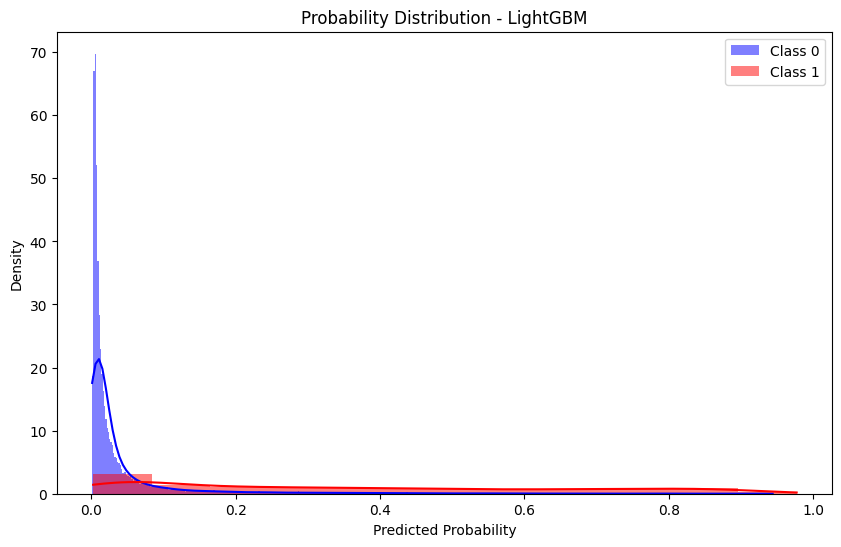


### LightGBM with missing filled as -1000 ###
Model: LightGBM
AUC (Train): 0.9608169552847781
AUC (Validation): 0.9007758895491086
AUC Difference: 0.060041065735669474
Recall: 0.32655190401669276
FP/TP Ratio: 0.44568690095846647
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28083
           1       0.69      0.33      0.44      1917

    accuracy                           0.95     30000
   macro avg       0.82      0.66      0.71     30000
weighted avg       0.94      0.95      0.94     30000

Confusion Matrix:
[[27804   279]
 [ 1291   626]]
Training Time: 70.90 seconds
Validation Time: 2.50 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


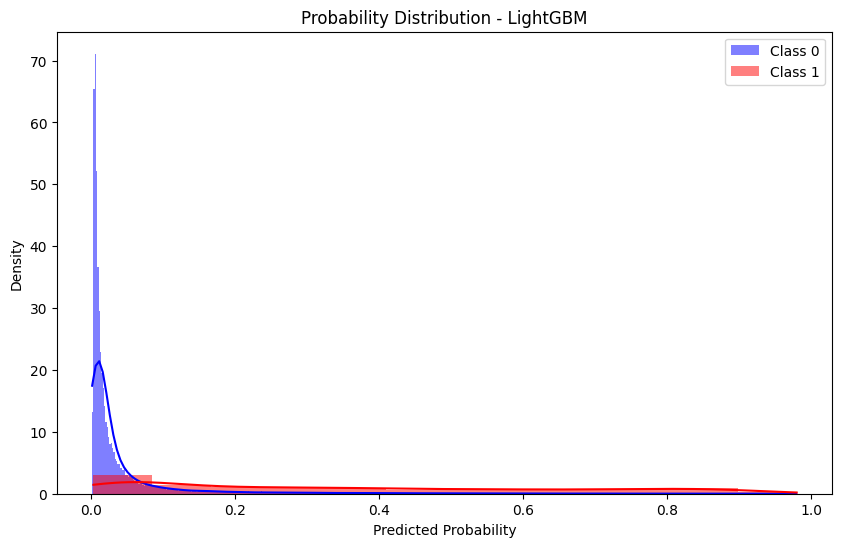


### XGBoost with missing filled as 0 ###
Model: XGBoost
AUC (Train): 0.9886149430134676
AUC (Validation): 0.8916456678244798
AUC Difference: 0.09696927518898779
Recall: 0.3359415753781951
FP/TP Ratio: 0.532608695652174
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28083
           1       0.65      0.34      0.44      1917

    accuracy                           0.95     30000
   macro avg       0.80      0.66      0.71     30000
weighted avg       0.94      0.95      0.94     30000

Confusion Matrix:
[[27740   343]
 [ 1273   644]]
Training Time: 141.83 seconds
Validation Time: 1.79 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


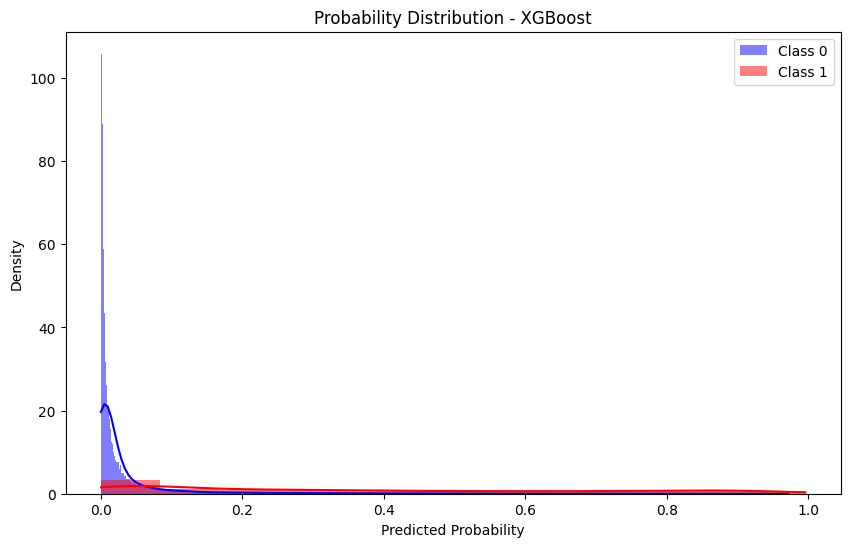


### XGBoost with missing filled as -1000 ###
Model: XGBoost
AUC (Train): 0.9880671242260665
AUC (Validation): 0.8891001636459894
AUC Difference: 0.09896696058007703
Recall: 0.3302034428794992
FP/TP Ratio: 0.5576619273301737
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28083
           1       0.64      0.33      0.44      1917

    accuracy                           0.95     30000
   macro avg       0.80      0.66      0.70     30000
weighted avg       0.94      0.95      0.94     30000

Confusion Matrix:
[[27730   353]
 [ 1284   633]]
Training Time: 140.65 seconds
Validation Time: 1.79 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


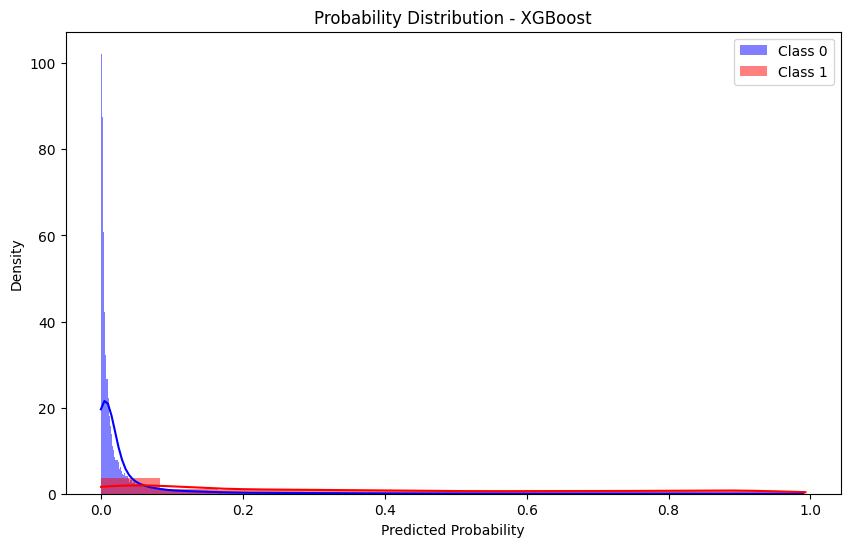


### RandomForest with missing filled as 0 ###
Model: RandomForest
AUC (Train): 1.0
AUC (Validation): 0.873463500428187
AUC Difference: 0.126536499571813
Recall: 0.2039645279081899
FP/TP Ratio: 0.3836317135549872
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28083
           1       0.72      0.20      0.32      1917

    accuracy                           0.94     30000
   macro avg       0.84      0.60      0.64     30000
weighted avg       0.93      0.94      0.93     30000

Confusion Matrix:
[[27933   150]
 [ 1526   391]]
Training Time: 412.61 seconds
Validation Time: 7.42 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


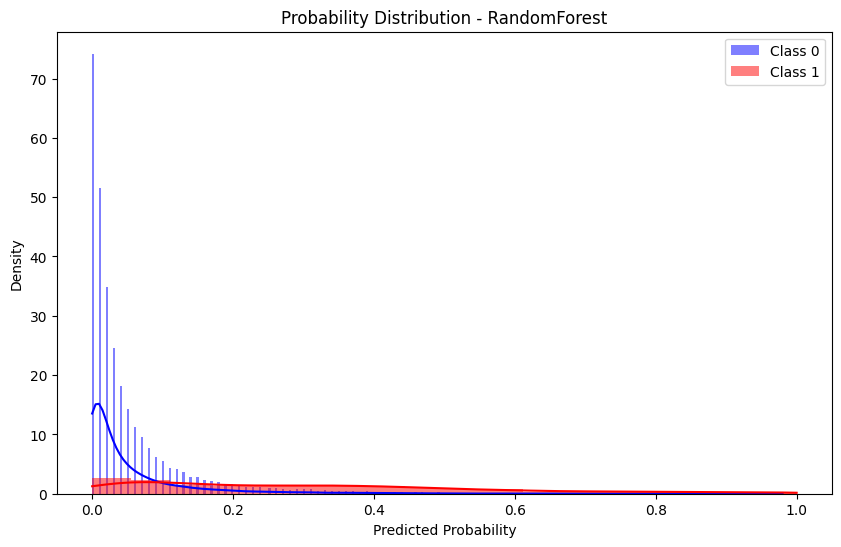


### RandomForest with missing filled as -1000 ###
Model: RandomForest
AUC (Train): 1.0
AUC (Validation): 0.8753732856610995
AUC Difference: 0.12462671433890049
Recall: 0.24569640062597808
FP/TP Ratio: 0.4437367303609342
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28083
           1       0.69      0.25      0.36      1917

    accuracy                           0.94     30000
   macro avg       0.82      0.62      0.67     30000
weighted avg       0.93      0.94      0.93     30000

Confusion Matrix:
[[27874   209]
 [ 1446   471]]
Training Time: 413.45 seconds
Validation Time: 7.45 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


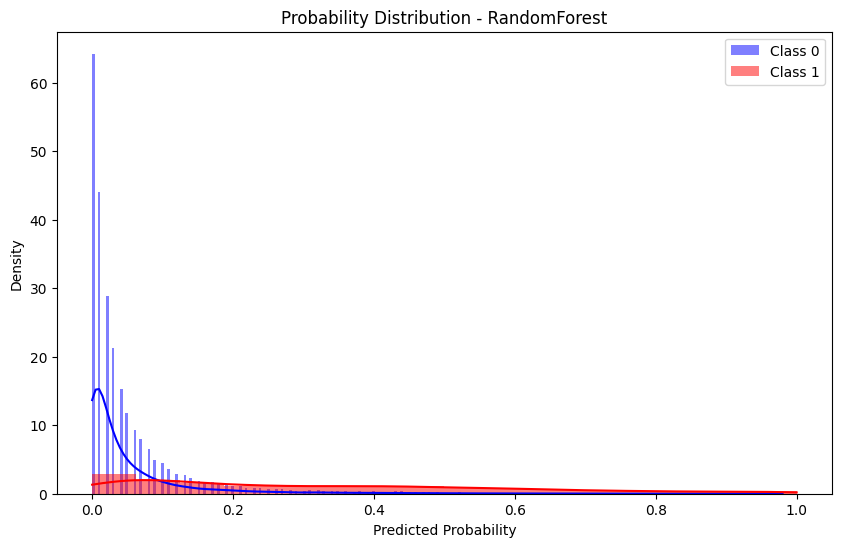

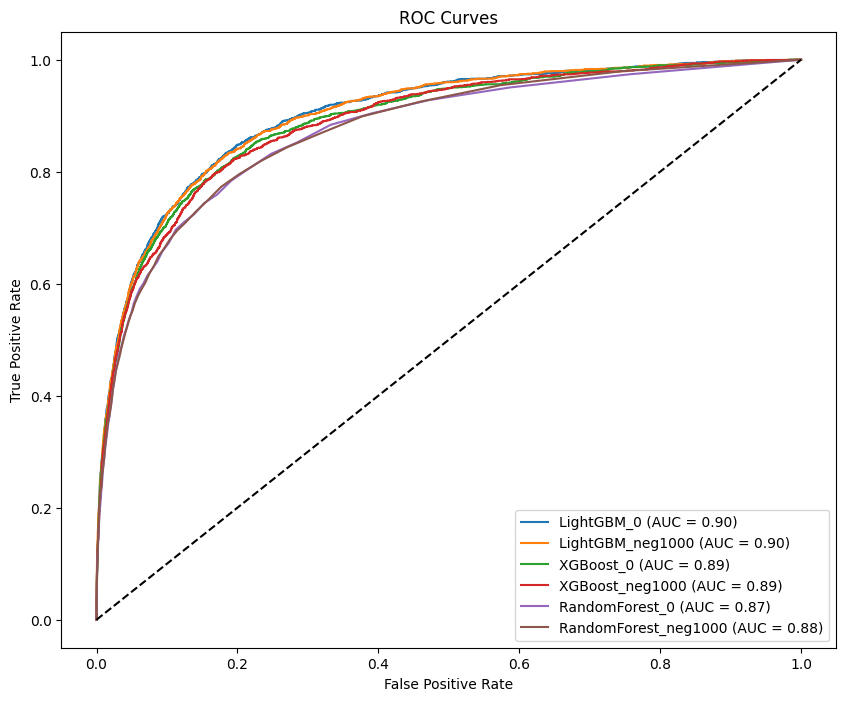

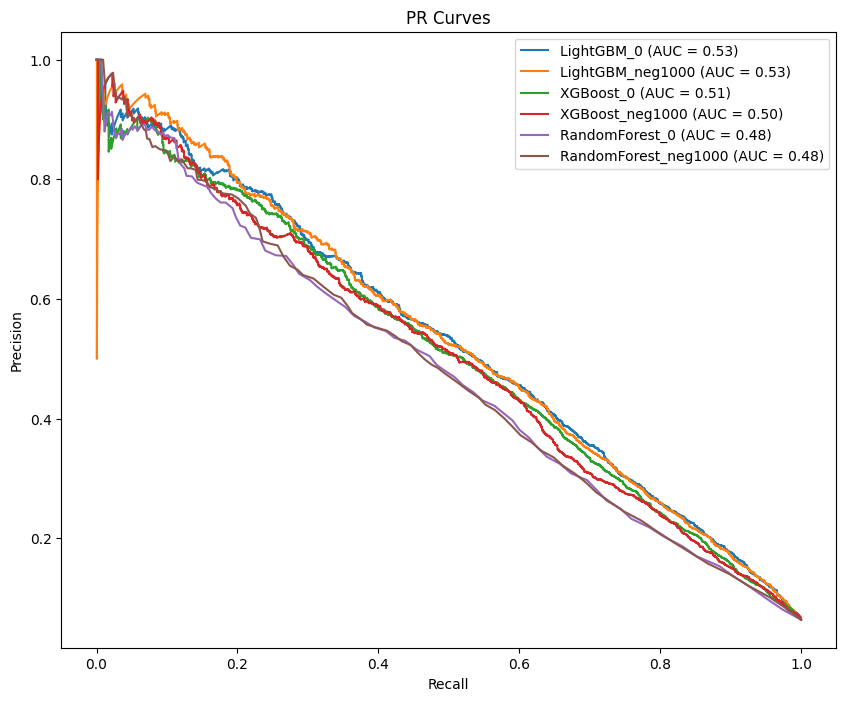

In [6]:
# Розглянемо два варіанти заповнення пропущених значень
X_train_0 = X_train.fillna(0)
X_val_0 = X_val.fillna(0)

X_train_neg1000 = X_train.fillna(-1000)
X_val_neg1000 = X_val.fillna(-1000)

models = [
    ('LightGBM', lgb.LGBMClassifier(verbose=-1, random_state=42)),
    ('XGBoost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42))
]

# Тренування і оцінка моделей для різних варіантів заповнення місінгів
results = {}
for model_name, model in models:
    print(f"\n### {model_name} with missing filled as 0 ###")
    results[f"{model_name}_0"] = train_and_evaluate(model, X_train_0, X_val_0, y_train, y_val, model_name)
    
    print(f"\n### {model_name} with missing filled as -1000 ###")
    results[f"{model_name}_neg1000"] = train_and_evaluate(model, X_train_neg1000, X_val_neg1000, y_train, y_val, model_name)

# Побудова ROC кривих для всіх моделей
plt.figure(figsize=(10, 8))
for key in results:
    fpr, tpr, _ = roc_curve(y_val, results[key])
    plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc_score(y_val, results[key]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Побудова PR кривих для всіх моделей
plt.figure(figsize=(10, 8))
for key in results:
    precision, recall, _ = precision_recall_curve(y_val, results[key])
    plt.plot(recall, precision, label=f'{key} (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves')
plt.legend()
plt.show()


## Функції для роботи з ознаками

In [ ]:
def remove_features_starting_with(df, prefix):
    columns_to_remove = [col for col in df.columns if col.startswith(prefix)]
    df = df.drop(columns=columns_to_remove)
    print(columns_to_remove)
    return df

def remove_features_ending_with(df, suffix):
    columns_to_remove = [col for col in df.columns if col.endswith(suffix)]
    df = df.drop(columns=columns_to_remove)
    print(columns_to_remove)
    return df

def remove_features_starting_and_ending_with(df, start_prefix, end_suffix):
    columns_to_remove = [col for col in df.columns if col.startswith(start_prefix) or col.endswith(end_suffix)]
    df = df.drop(columns=columns_to_remove)
    print(columns_to_remove)
    return df

def remove_features_from_list(df, feature_list):
    df = df.drop(columns=feature_list, errors='ignore')
    return df

def create_sum_feature_and_remove(df, new_feature_name, features_to_sum):
    df[new_feature_name] = df[features_to_sum].sum(axis=1)
    df = df.drop(columns=features_to_sum)
    return df

def remove_features_by_suffix(df, suffixes):
    columns_to_remove = [col for col in df.columns if any(col.endswith(suffix) for suffix in suffixes)]
    df.drop(columns=columns_to_remove, inplace=True)
    return df

def create_new_feature_and_remove_old(df, feature1, feature2, new_feature_name):
    df[new_feature_name] = df[feature1] / df[feature2]
    df.drop(columns=[feature1, feature2], inplace=True)
    
def calculate_trend(feature1, feature2, feature3):
    trend1 = (feature2 - feature1) / feature1
    trend2 = (feature3 - feature2) / feature2
    average_trend = (trend1 + trend2) / 2
    return average_trend

def create_trend_feature_and_remove_old(df, feature1, feature2, feature3, new_feature_name):
    df[new_feature_name] = calculate_trend(df[feature1], df[feature2], df[feature3])
    df.drop(columns=[feature1, feature2, feature3], inplace=True)



In [ ]:
# ВИДАЛЕННЯ ОЗНАК ЩО ЗАКІНЧУЮТЬСЯ НА РІЗНІ 
suffixes_to_remove = [
    '_mea_wk1', '_max_mnt1', '_min_mnt1', '_std_mnt1', 
    '_max_mnt3', '_min_mnt3', '_std_mnt3'
]

df_train_fe1 = remove_features_by_suffix(df_train_fe, suffixes_to_remove)
df_test_fe1 = remove_features_by_suffix(df_test_fe, suffixes_to_remove)

In [ ]:
# ПАРИ ОЗНАК - СТВОРЕННЯ НОВОЇ ВІДНОШЕННЯ ДВОХ ТА ВИДАЛЕННЯ ПАРИ

features_pairs = [
    ('BS_OVERBUNDLE_MB_CNT_M1', 'BS_OVERBUNDLE_MB_SUM_M1'),
    ('BS_OVERBUNDLE_MB_CNT_M2', 'BS_OVERBUNDLE_MB_SUM_M2'),
    ('BS_OVERBUNDLE_MB_CNT_M3', 'BS_OVERBUNDLE_MB_SUM_M3'),
    ('bs_ovrl_OMO_CNT_M3', 'bs_ovrl_OMO_SUM_M3'),
    ('bs_ovrl_OMO_CNT_M2', 'bs_ovrl_OMO_SUM_M2'),
    ('bs_ovrl_OMO_CNT_M1', 'bs_ovrl_OMO_SUM_M1')
]

for feature1, feature2 in features_pairs:
    new_feature_name = f"{feature1}_DIV_{feature2}"
    create_new_feature_and_remove_old(df_train_fe, feature1, feature2, new_feature_name)
    create_new_feature_and_remove_old(df_test_fe, feature1, feature2, new_feature_name)

In [ ]:
# ТРИ ОЗНАКИ ТРЕНД 

features_triplets = [
    ('BS_OVERBUNDLE_MB_CNT_M1', 'BS_OVERBUNDLE_MB_CNT_M2', 'BS_OVERBUNDLE_MB_CNT_M3'),
    ('BS_OVERBUNDLE_MB_SUM_M1', 'BS_OVERBUNDLE_MB_SUM_M2', 'BS_OVERBUNDLE_MB_SUM_M3'),
    ('bs_ovrl_OMO_CNT_M1', 'bs_ovrl_OMO_CNT_M2', 'bs_ovrl_OMO_CNT_M3'),
    ('bs_ovrl_OMO_SUM_M1', 'bs_ovrl_OMO_SUM_M2', 'bs_ovrl_OMO_SUM_M3')
]

for feature1, feature2, feature3 in features_triplets:
    new_feature_name = f"TREND_{feature1}_{feature2}_{feature3}"
    create_trend_feature_and_remove_old(df_train_fe, feature1, feature2, feature3, new_feature_name)
    create_trend_feature_and_remove_old(df_test_fe, feature1, feature2, feature3, new_feature_name)

In [ ]:
# ПОЧИНАЄТЬСЯ
df_train_fe1 = remove_features_starting_with(df_train_fe, 'all_home_')
df_test_fe1 = remove_features_starting_with(df_test_fe, 'all_home_')

In [ ]:
# ЗАКІНЧУЄТЬСЯ
df_train_fe1 = remove_features_ending_with(df_train_fe, '_wk1')
df_test_fe1 = remove_features_ending_with(df_test_fe, '_wk1')

In [ ]:
# ПОЧИНАЄТЬСЯ ТА ЗАКІНЧУЄТЬСЯ
df_train_fe1 = remove_features_starting_and_ending_with(df_train_fe, '_td_mnt3')
df_test_fe1 = remove_features_starting_and_ending_with(df_test_fe, '_td_mnt3')

In [ ]:
# ВИДАЛЕННЯ СПИСКУ ОЗНАК

features_to_remove = [
    'MV_ARPU_2G_d_Traf',
    'MV_Traf_2G_d_Mb',
    'MV_ARPU_3G_d_Traf',
    'MV_Traf_3G_d_Mb',
    'MV_ARPU_4G_d_Traf',
    'MV_Traf_4G_d_Mb'
]

df_train_fe1 = remove_features_from_list(df_train_fe, features_to_remove)
df_test_fe1 = remove_features_from_list(df_test_fe, features_to_remove)

In [ ]:
# ВИДАЛЕННЯ СПИСКУ ОЗНАК

features_to_remove = ['voice_mts_in_dwork_part_mea_wk1', 'voice_mts_out_dwork_partmea_wk1', 'voice_out_fix_tar_dur_mea_wk1', 'voice_in_roam_clc_mea_wk1', 'pay_p2p_in_sum_mea_wk1', 'vas_clc_mea_wk1', 'conn_in_uniq_cnt_mea_wk1', 'data_3g_tv_cnt_mea_wk1', 'voice_out_short_part_mea_wk1', 'voice_in_fix_tar_dur_mea_wk1', 'pay_max_mea_wk1', 'gprs_tar_vol_mea_wk1', 'conn_out_uniq_cnt_mea_wk1', 'voice_out_cmpttrs_td_cntmea_wk1', 'data_3g_dou_mea_wk1', 'gprs_clc_mea_wk1', 'all_clc_mea_wk1', 'sms_out_cnt_mea_wk1', 'all_roam_clc_mea_wk1', 'num_act_days_mea_wk1', 'abon_part_mea_wk1', 'all_home_clc_mea_wk1', 'sms_clc_mea_wk1', 'clc_no_vas_roam_mea_wk1', 'voice_mts_out_drest_partmea_wk1', 'voice_out_cmpttrs_avg_dumea_wk1', 'data_3g_tar_vol_mea_wk1', 'voice_in_short_part_mea_wk1', 'block_all_dur_mea_wk1', 'voice_in_life_part_mea_wk1', 'voice_in_cmpttrs_td_cnt_mea_wk1', 'ama_volume_mea_wk1', 'pay_avg_mea_wk1', 'content_clc_mea_wk1', 'pay_p2p_out_sum_mea_wk1', 'com_num_part_mea_wk1', 'voice_mts_out_nrest_partmea_wk1', 'accum_mts_dur_mea_wk1', 'accum_oth_dur_mea_wk1', 'voice_in_kievstar_part_mea_wk1', 'all_cnt_mea_wk1', 'voice_mts_in_nwork_part_mea_wk1', 'voice_in_mts_avg_dur_mea_wk1', 'voice_mts_out_nwork_partmea_wk1', 'pay_sum_mea_wk1', 'voice_in_td_cnt_mea_wk1']

df_train_fe1 = remove_features_from_list(df_train_fe, features_to_remove)
df_test_fe1 = remove_features_from_list(df_test_fe, features_to_remove)

In [ ]:
# ДОДАВАННЯ ОЗНАКИ ЩО Є СУМОЮ ОЗНАК
features_to_sum = ['MV_dou_2G_d',
'MV_dou_3G_d',
'MV_dou_4G_d'
]
new_feature_name = 'MV_dou_total'

df_train_fe1 = create_sum_feature_and_remove(df_train_fe, new_feature_name, features_to_sum)
df_test_fe1 = create_sum_feature_and_remove(df_test_fe, new_feature_name, features_to_sum)


In [ ]:
features_to_sum = ['MV_Traf_2G_d_Mb', 'MV_Traf_3G_d_Mb', 'MV_Traf_4G_d_Mb']
new_feature_name = 'MV_Traf_total_cnt'

df_train_fe1[new_feature_name] = df_train_fe1[features_to_sum].sum(axis=1)
df_train_fe1 = df_train_fe1.drop(columns=features_to_sum)

df_test_fe1[new_feature_name] = df_test_fe1[features_to_sum].sum(axis=1)
df_test_fe1 = df_test_fe1.drop(columns=features_to_sum)

## Пропущені значення та балансування класів


### LightGBM with missings ###
Model: LightGBM
AUC (Train): 0.9606318778484649
AUC (Validation): 0.900576224315763
AUC Difference: 0.060055653532701925
Recall: 0.3249869587897757
FP/TP Ratio: 0.4606741573033708
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28083
           1       0.68      0.32      0.44      1917

    accuracy                           0.95     30000
   macro avg       0.82      0.66      0.71     30000
weighted avg       0.94      0.95      0.94     30000

Confusion Matrix:
[[27796   287]
 [ 1294   623]]
Training Time: 40.65 seconds
Validation Time: 2.70 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


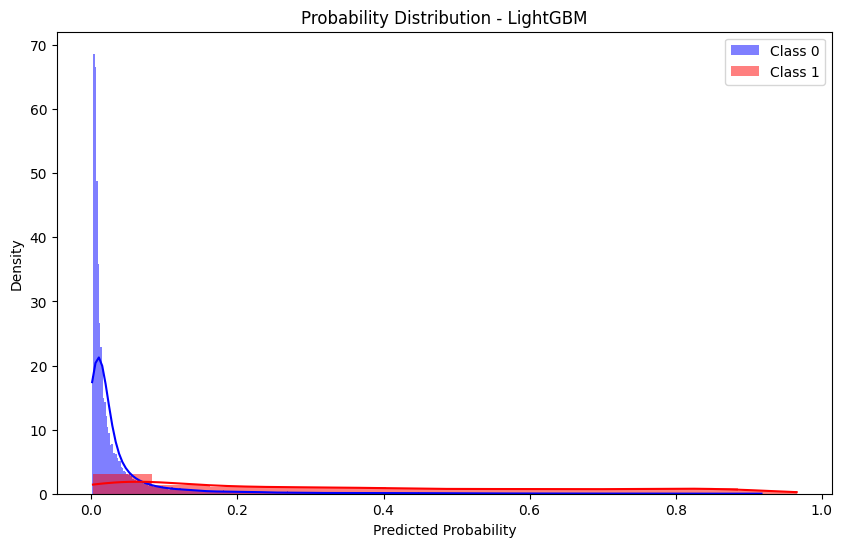


### XGBoost with missings ###
Model: XGBoost
AUC (Train): 0.9881223910337382
AUC (Validation): 0.8909284314469046
AUC Difference: 0.09719395958683363
Recall: 0.3338549817423057
FP/TP Ratio: 0.553125
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28083
           1       0.64      0.33      0.44      1917

    accuracy                           0.95     30000
   macro avg       0.80      0.66      0.71     30000
weighted avg       0.94      0.95      0.94     30000

Confusion Matrix:
[[27729   354]
 [ 1277   640]]
Training Time: 69.37 seconds
Validation Time: 1.87 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


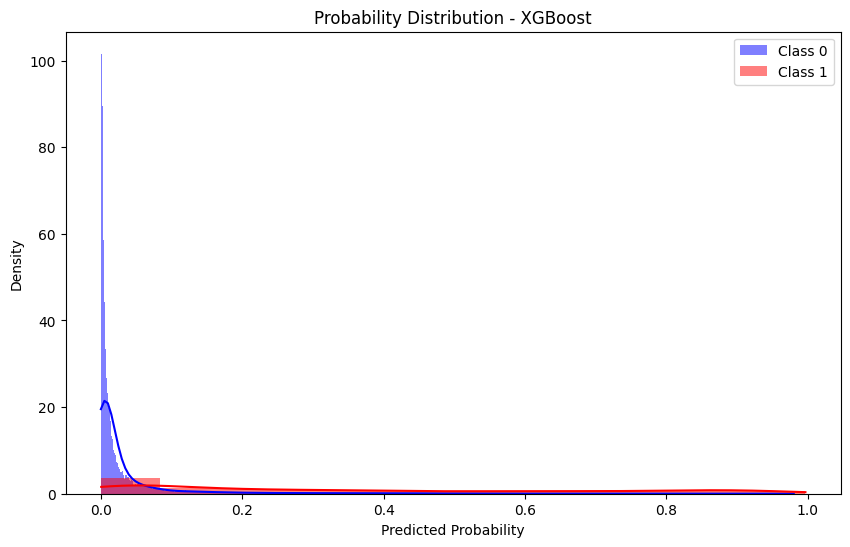

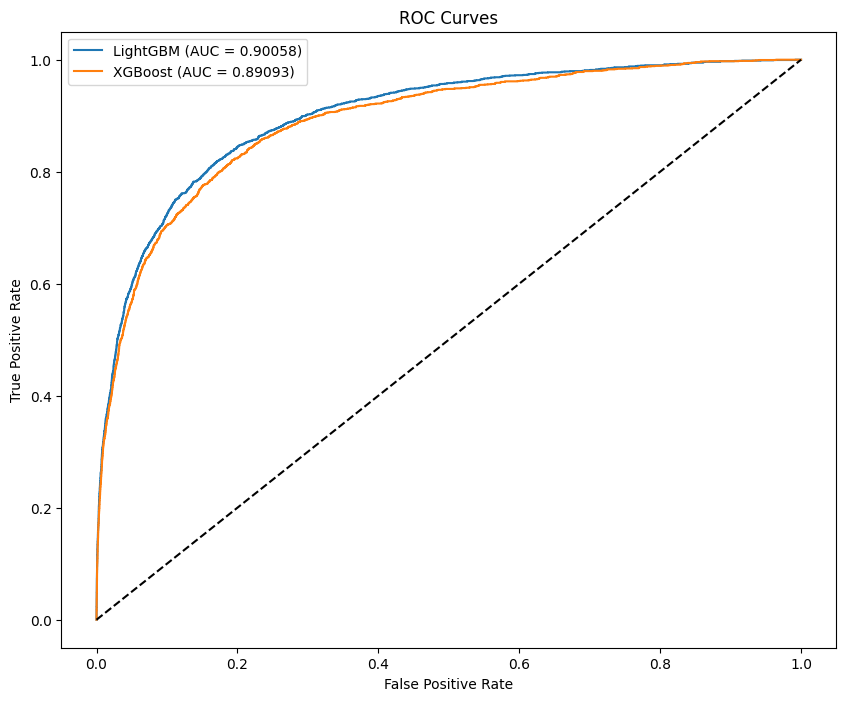

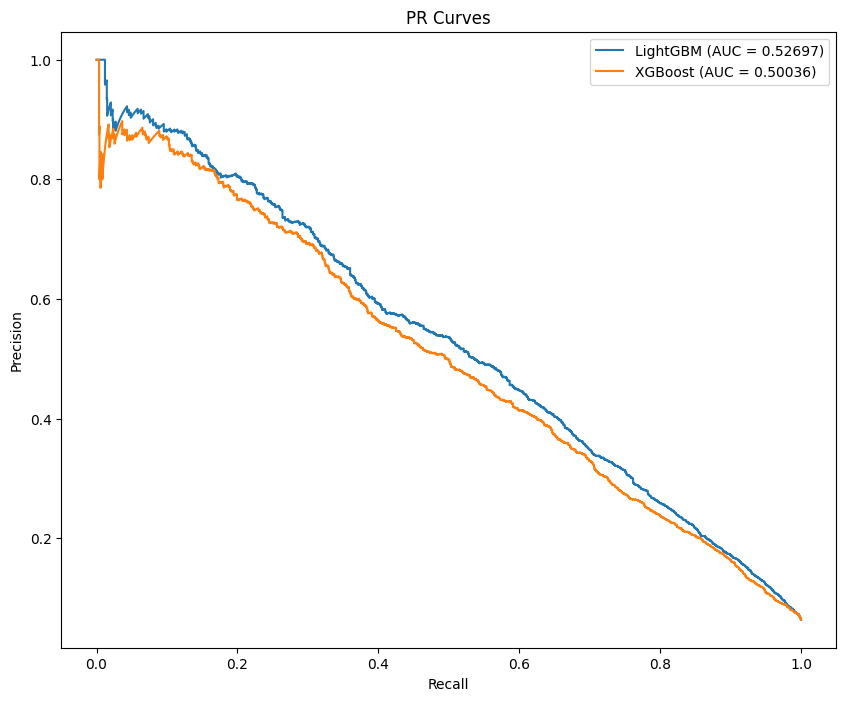

In [10]:
models = [
    ('LightGBM', lgb.LGBMClassifier(verbose=-1, random_state=42)),
    ('XGBoost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
]

results = {}
for model_name, model in models:
    print(f"\n### {model_name} with missings ###")
    results[f"{model_name}"] = train_and_evaluate(model, X_train, X_val, y_train, y_val, model_name)

plt.figure(figsize=(10, 8))
for key in results:
    fpr, tpr, _ = roc_curve(y_val, results[key])
    plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc_score(y_val, results[key]):.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for key in results:
    precision, recall, _ = precision_recall_curve(y_val, results[key])
    plt.plot(recall, precision, label=f'{key} (AUC = {auc(recall, precision):.5f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves')
plt.legend()
plt.show()



### LightGBM with missing values as is ###
Model: LightGBM
AUC (Train): 0.9541982270600214
AUC (Validation): 0.9021430827921948
AUC Difference: 0.05205514426782665
Recall: 0.7798643714136672
FP/TP Ratio: 2.4642140468227423
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     28083
           1       0.29      0.78      0.42      1917

    accuracy                           0.86     30000
   macro avg       0.64      0.82      0.67     30000
weighted avg       0.94      0.86      0.89     30000

Confusion Matrix:
[[24399  3684]
 [  422  1495]]
Training Time: 121.98 seconds
Validation Time: 5.10 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


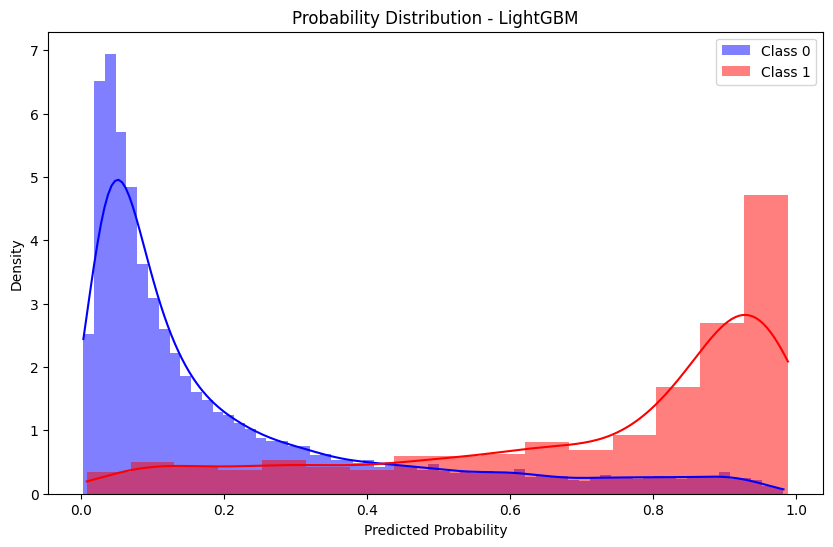


### LightGBM with missing filled as 0 ###
Model: LightGBM
AUC (Train): 0.9535240914152684
AUC (Validation): 0.9011809226138681
AUC Difference: 0.05234316880140033
Recall: 0.7809076682316118
FP/TP Ratio: 2.4629258517034067
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     28083
           1       0.29      0.78      0.42      1917

    accuracy                           0.86     30000
   macro avg       0.64      0.82      0.67     30000
weighted avg       0.94      0.86      0.89     30000

Confusion Matrix:
[[24396  3687]
 [  420  1497]]
Training Time: 111.07 seconds
Validation Time: 5.01 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


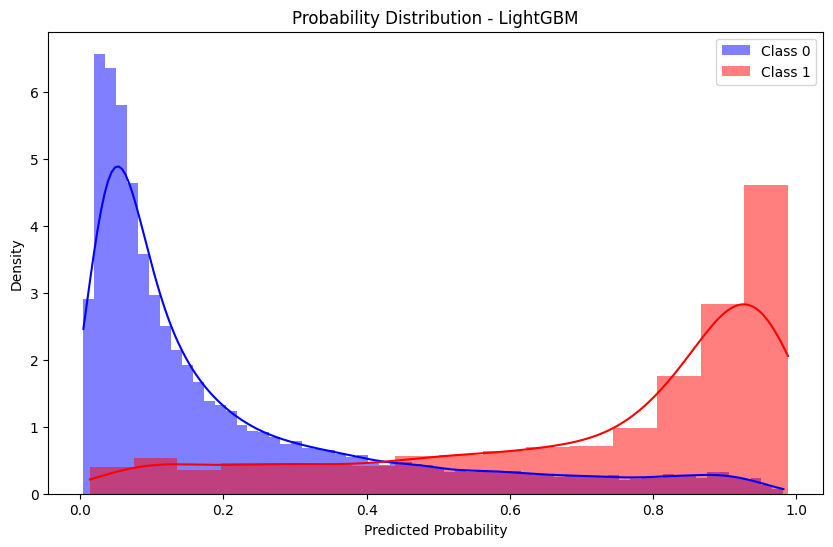


### LightGBM with missing filled as -1000 ###
Model: LightGBM
AUC (Train): 0.9533913304518038
AUC (Validation): 0.9017261987255863
AUC Difference: 0.05166513172621745
Recall: 0.7767344809598331
FP/TP Ratio: 2.5271994627266623
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     28083
           1       0.28      0.78      0.42      1917

    accuracy                           0.86     30000
   macro avg       0.63      0.82      0.67     30000
weighted avg       0.94      0.86      0.89     30000

Confusion Matrix:
[[24320  3763]
 [  428  1489]]
Training Time: 124.62 seconds
Validation Time: 5.02 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


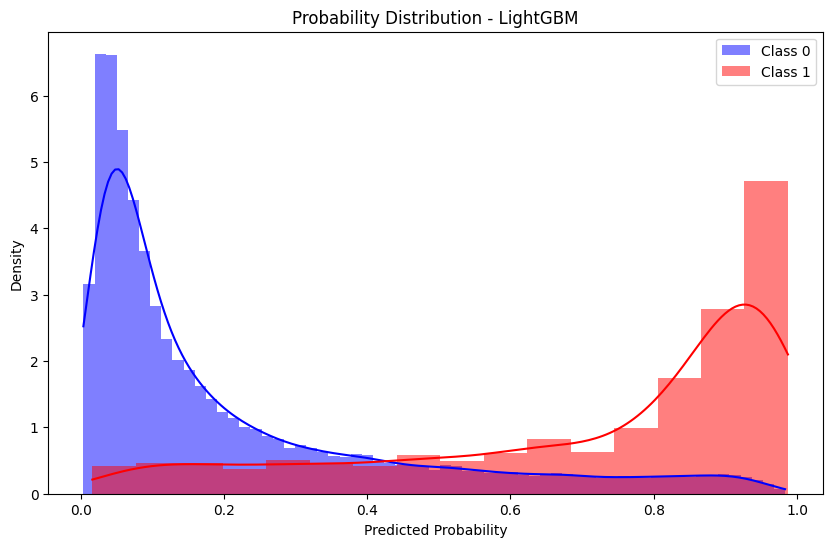


### XGBoost with missing values as is ###
Model: XGBoost
AUC (Train): 0.9860999013728726
AUC (Validation): 0.8864635386374515
AUC Difference: 0.09963636273542109
Recall: 0.6703182055294732
FP/TP Ratio: 1.9315175097276265
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     28083
           1       0.34      0.67      0.45      1917

    accuracy                           0.90     30000
   macro avg       0.66      0.79      0.70     30000
weighted avg       0.94      0.90      0.91     30000

Confusion Matrix:
[[25601  2482]
 [  632  1285]]
Training Time: 118.14 seconds
Validation Time: 4.01 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


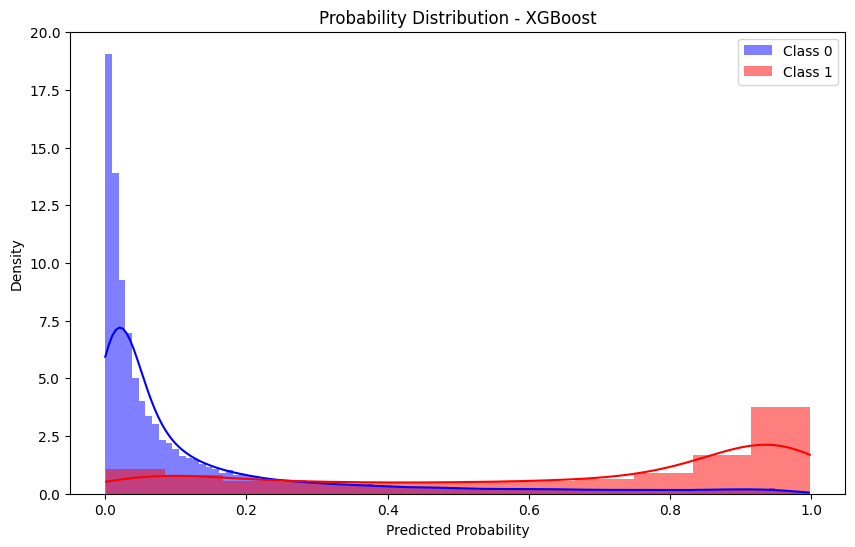


### XGBoost with missing filled as 0 ###
Model: XGBoost
AUC (Train): 0.9855802508548116
AUC (Validation): 0.8861595455798355
AUC Difference: 0.09942070527497615
Recall: 0.6802295252999478
FP/TP Ratio: 1.9608895705521472
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     28083
           1       0.34      0.68      0.45      1917

    accuracy                           0.89     30000
   macro avg       0.66      0.79      0.70     30000
weighted avg       0.94      0.89      0.91     30000

Confusion Matrix:
[[25526  2557]
 [  613  1304]]
Training Time: 234.84 seconds
Validation Time: 3.74 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


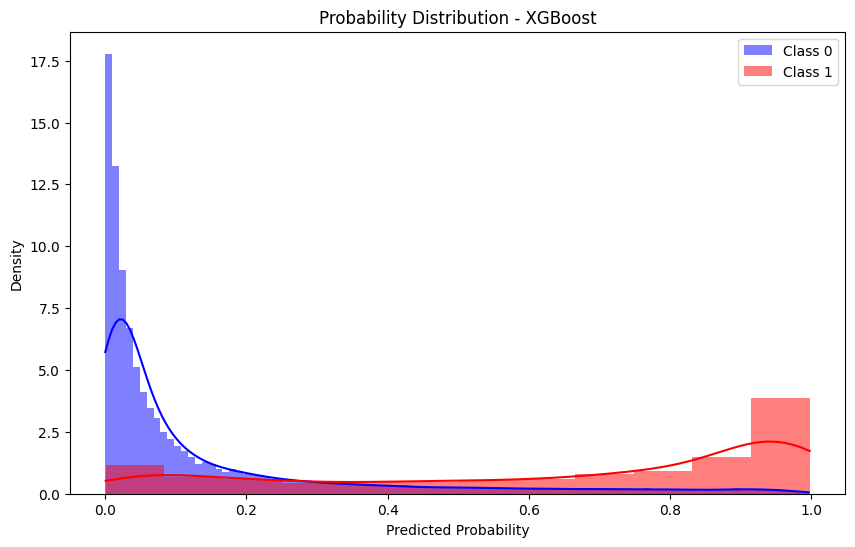


### XGBoost with missing filled as -1000 ###
Model: XGBoost
AUC (Train): 0.9855716100393871
AUC (Validation): 0.8848469449612538
AUC Difference: 0.10072466507813327
Recall: 0.6802295252999478
FP/TP Ratio: 1.9654907975460123
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     28083
           1       0.34      0.68      0.45      1917

    accuracy                           0.89     30000
   macro avg       0.66      0.79      0.70     30000
weighted avg       0.94      0.89      0.91     30000

Confusion Matrix:
[[25520  2563]
 [  613  1304]]
Training Time: 164.43 seconds
Validation Time: 4.00 seconds


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


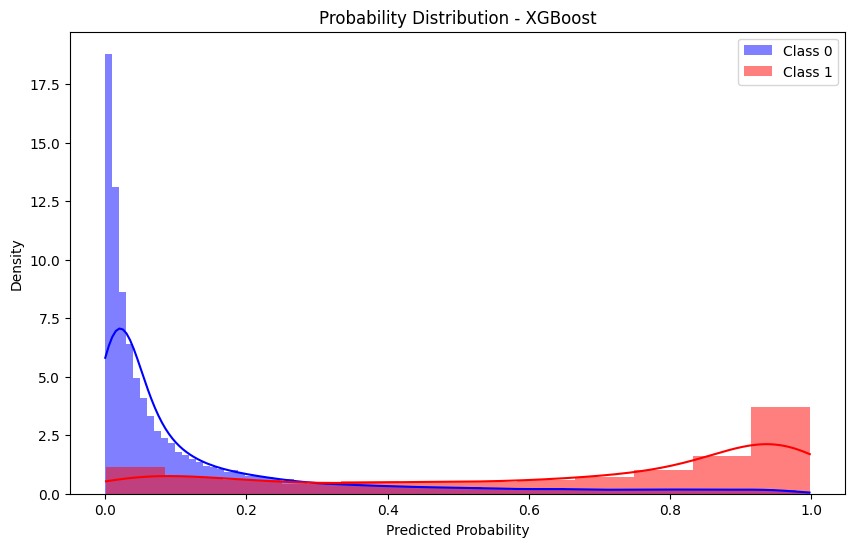

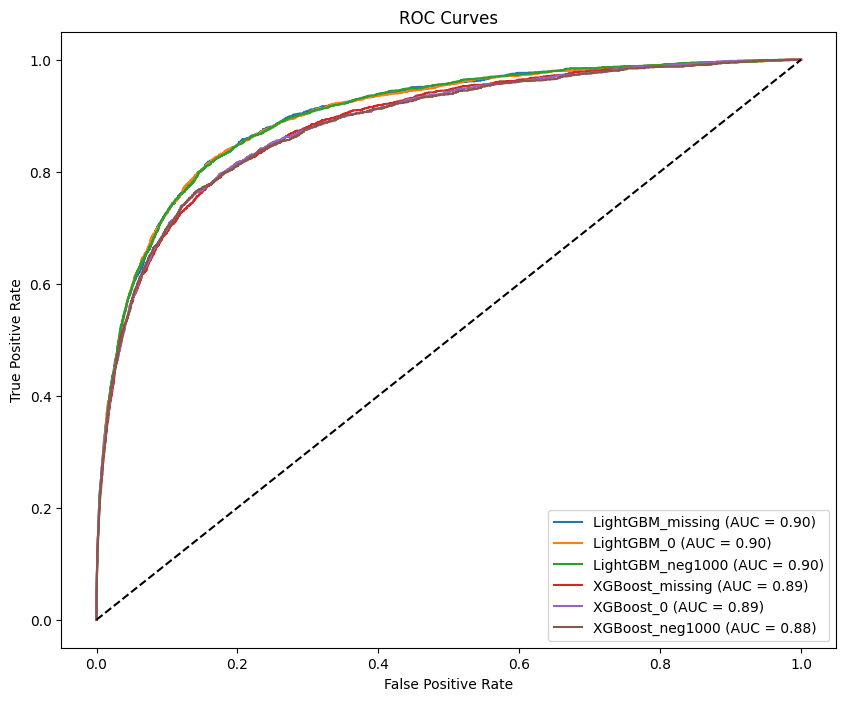

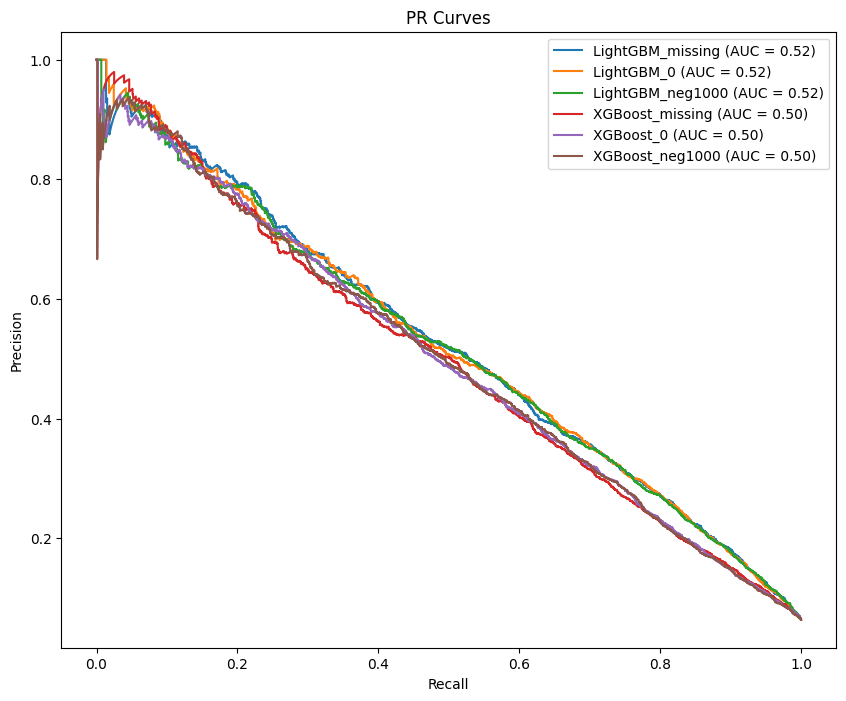

In [11]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

X_train_0 = X_train_res.fillna(0)
X_val_0 = X_val.fillna(0)

X_train_neg1000 = X_train_res.fillna(-1000)
X_val_neg1000 = X_val.fillna(-1000)

models = [
    ('LightGBM', lgb.LGBMClassifier(verbose=-1, random_state=42)),
    ('XGBoost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

results = {}
for model_name, model in models:
    print(f"\n### {model_name} with missing values as is ###")
    results[f"{model_name}_missing"] = train_and_evaluate(model, X_train_res, X_val, y_train_res, y_val, model_name)
    
    print(f"\n### {model_name} with missing filled as 0 ###")
    results[f"{model_name}_0"] = train_and_evaluate(model, X_train_0, X_val_0, y_train_res, y_val, model_name)
    
    print(f"\n### {model_name} with missing filled as -1000 ###")
    results[f"{model_name}_neg1000"] = train_and_evaluate(model, X_train_neg1000, X_val_neg1000, y_train_res, y_val, model_name)

plt.figure(figsize=(10, 8))
for key in results:
    fpr, tpr, _ = roc_curve(y_val, results[key])
    plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc_score(y_val, results[key]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for key in results:
    precision, recall, _ = precision_recall_curve(y_val, results[key])
    plt.plot(recall, precision, label=f'{key} (AUC = {auc(recall, precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves')
plt.legend()
plt.show()


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, f1_score

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

lgb_params = {
    'random_state': 42,
    'verbose': -1    
}

skf = StratifiedKFold(n_splits=5)

auc_scores = []
f1_scores = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_val = lgb.Dataset(X_val_fold, y_val_fold, reference=lgb_train)

    model = lgb.train(lgb_params, lgb_train, valid_sets=[lgb_train, lgb_val])

    y_val_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, (y_val_pred > 0.5).astype(int))
    
    auc_scores.append(auc)
    f1_scores.append(f1)

    print(f'Fold AUC: {auc}, Fold F1: {f1}')

print(f'Mean AUC: {sum(auc_scores)/len(auc_scores)}, Mean F1: {sum(f1_scores)/len(f1_scores)}')

final_model = lgb.train(lgb_params, lgb.Dataset(X_train, y_train), valid_sets=[lgb.Dataset(X_val, y_val)])

y_val_pred_proba = final_model.predict(X_val, num_iteration=final_model.best_iteration)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

final_auc = roc_auc_score(y_val, y_val_pred_proba)
final_f1 = f1_score(y_val, y_val_pred)
final_recall = recall_score(y_val, y_val_pred)
final_cm = confusion_matrix(y_val, y_val_pred)

print(f'Final Validation AUC: {final_auc}, Final Validation F1: {final_f1}')
print(f"Recall: {final_recall}")
print(f"Confusion Matrix:\n{final_cm}")

Fold AUC: 0.8872129075532423, Fold F1: 0.42047026279391425
Fold AUC: 0.9026957554634782, Fold F1: 0.4358154408405665
Fold AUC: 0.897261409998548, Fold F1: 0.4179651695692025
Fold AUC: 0.8890678029938563, Fold F1: 0.424860853432282
Fold AUC: 0.8982503301236543, Fold F1: 0.40841121495327115
Mean AUC: 0.8948976412265559, Mean F1: 0.42150458831784726
Final Validation AUC: 0.8979213584235016, Final Validation F1: 0.42982456140350866
Recall: 0.30672926447574334
Confusion Matrix:
[[27852   231]
 [ 1329   588]]


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_filled = X_train.fillna(0)
X_val_filled = X_val.fillna(0)

def train_evaluate_model(X_train, y_train, X_val, y_val, balance_method=None, is_unbalance=False):
    if balance_method == 'undersampling':
        rus = RandomUnderSampler(random_state=42)
        X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
    elif balance_method == 'oversampling':
        ros = RandomOverSampler(random_state=42)
        X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
    else:
        X_train_balanced = X_train
        y_train_balanced = y_train
        
    train_data = lgb.Dataset(X_train_balanced, label=y_train_balanced)
    val_data = lgb.Dataset(X_val, label=y_val)
        
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': is_unbalance,
        'boosting_type': 'gbdt',
        'verbosity': -1
    }
        
    model = lgb.train(params, train_data, valid_sets=[train_data, val_data])
        
    y_train_pred = model.predict(X_train_balanced)
    y_val_pred = model.predict(X_val)
        
    train_auc = roc_auc_score(y_train_balanced, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)
    recall = recall_score(y_val, (y_val_pred > 0.5).astype(int))
    cm = confusion_matrix(y_val, (y_val_pred > 0.5).astype(int))
    fp_tp_ratio = cm[0, 1] / cm[1, 1] if cm[1, 1] != 0 else np.inf
    
    return {
        'train_auc': train_auc,
        'val_auc': val_auc,
        'auc_diff': train_auc - val_auc,
        'recall': recall,
        'fp_tp_ratio': fp_tp_ratio
    }

results_original = []
for method in [None, 'undersampling', 'oversampling']:
    result = train_evaluate_model(X_train, y_train, X_val, y_val, balance_method=method, is_unbalance=False)
    result['method'] = method or 'none'
    result['dataset'] = 'original'
    results_original.append(result)

result_unbalance = train_evaluate_model(X_train, y_train, X_val, y_val, balance_method=None, is_unbalance=True)
result_unbalance['method'] = 'none'
result_unbalance['dataset'] = 'original'
results_original.append(result_unbalance)

results_filled = []
for method in [None, 'undersampling', 'oversampling']:
    result = train_evaluate_model(X_train_filled, y_train, X_val_filled, y_val, balance_method=method, is_unbalance=False)
    result['method'] = method or 'none'
    result['dataset'] = 'filled'
    results_filled.append(result)

result_unbalance_filled = train_evaluate_model(X_train_filled, y_train, X_val_filled, y_val, balance_method=None, is_unbalance=True)
result_unbalance_filled['method'] = 'none'
result_unbalance_filled['dataset'] = 'filled'
results_filled.append(result_unbalance_filled)

results_df = pd.DataFrame(results_original + results_filled)
results_df


,train_auc,val_auc,auc_diff,recall,fp_tp_ratio,method,dataset
0,0.960632,0.900576,0.060056,0.324987,0.460674,none,original
1,0.975632,0.899884,0.075748,0.812728,2.915276,undersampling,original
2,0.954035,0.902859,0.051176,0.781429,2.481308,oversampling,original
3,0.955940,0.902082,0.053858,0.785603,2.496680,none,original
4,0.961044,0.901657,0.059387,0.325509,0.491987,none,filled
5,0.974064,0.899157,0.074907,0.810120,2.952350,undersampling,filled
6,0.953052,0.901154,0.051898,0.781951,2.501668,oversampling,filled
7,0.955409,0.902270,0.053139,0.782994,2.498334,none,filled


## Важливість ознак

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, classification_report, confusion_matrix
import lightgbm as lgb

X = df_train_fe.drop(columns=['target'])
y = df_train_fe['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'boosting_type': 'gbdt',
    'verbosity': -1
}

model = lgb.train(params, train_data, valid_sets=[train_data, val_data])

feature_importance = model.feature_importance(importance_type='gain')
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

def train_evaluate_model_subset(X_train, y_train, X_val, y_val, features):
    X_train_subset = X_train[features]
    X_val_subset = X_val[features]
    
    train_data = lgb.Dataset(X_train_subset, label=y_train)
    val_data = lgb.Dataset(X_val_subset, label=y_val)
    
    model = lgb.train(params, train_data, valid_sets=[train_data, val_data])
    
    y_train_pred = model.predict(X_train_subset)
    y_val_pred = model.predict(X_val_subset)
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)
    recall = recall_score(y_val, (y_val_pred > 0.5).astype(int))
    cm = confusion_matrix(y_val, (y_val_pred > 0.5).astype(int))
    fp_tp_ratio = cm[0, 1] / cm[1, 1] if cm[1, 1] != 0 else np.inf
    
    return {
        'train_auc': train_auc,
        'val_auc': val_auc,
        'auc_diff': train_auc - val_auc,
        'recall': recall,
        'fp_tp_ratio': fp_tp_ratio,
        'classification_report': classification_report(y_val, (y_val_pred > 0.5).astype(int)),
        'confusion_matrix': cm,
        'num_features': len(features),
        'features': features
    }

results = []
for num_features in (25, 241, 454):
#for num_features in range(10, 601, 1):
    top_features = feature_importance_df['feature'].iloc[:num_features].tolist()
    result = train_evaluate_model_subset(X_train, y_train, X_val, y_val, top_features)
    result['num_features'] = num_features
    results.append(result)

best_by_auc = max(results, key=lambda x: x['val_auc'])
best_by_recall = max(results, key=lambda x: x['recall'])
best_by_fp_tp_ratio = min(results, key=lambda x: x['fp_tp_ratio'])

def print_results(title, result):
    print(f"{title}:")
    print(f"Number of Features: {result['num_features']}")
    print(f"Features: {result['features']}")
    print(f"Train AUC: {result['train_auc']}")
    print(f"Validation AUC: {result['val_auc']}")
    print(f"AUC Difference: {result['auc_diff']}")
    print(f"Recall: {result['recall']}")
    print(f"FP/TP Ratio: {result['fp_tp_ratio']}")
    print("Classification Report:")
    print(result['classification_report'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("\n" + "="*50 + "\n")

print_results("Best by AUC", best_by_auc)
print_results("Best by Recall", best_by_recall)
print_results("Best by FP/TP Ratio", best_by_fp_tp_ratio)

top_25_features = feature_importance_df['feature'].iloc[:25].tolist()
top_241_features = feature_importance_df['feature'].iloc[:241].tolist()
top_454_features = feature_importance_df['feature'].iloc[:454].tolist()

df_top_25_features = pd.DataFrame(top_25_features, columns=['feature'])
df_top_241_features = pd.DataFrame(top_241_features, columns=['feature'])
df_top_454_features = pd.DataFrame(top_454_features, columns=['feature'])

df_top_25_features.to_csv('top_25_features.csv', index=False)
df_top_241_features.to_csv('top_241_features.csv', index=False)
df_top_454_features.to_csv('top_454_features.csv', index=False)

print("Файли успішно збережено.")

Best by AUC:
Number of Features: 241
Features: ['num_act_days_min_mnt3', 'device_days_usage', 'loc_market_share', 'num_act_days_mea_mnt1', 'voice_in_td_cnt_mea_mnt1', 'device_brand_prestigio', 'num_act_days_mea_mnt3', 'lt', 'loc_is_obl_center', 'day_end_gba', 'days_of_last_ppm', 'num_act_days_min_mnt1', 'sms_in_cnt_std_mnt3', 'device_type_modem', 'all_cnt_std_mnt3', 'days_of_end_last_ppm', 'voice_out_tar_dur_min_mnt3', 'Balance_uah', 'all_cnt_max_mnt1', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'bs_count_ppm_mn3', 'conn_out_uniq_cnt_mea_mnt1', 'all_cnt_std_mnt1', 'data_3g_tv_cnt_std_mnt1', 'data_3g_tv_cnt_max_mnt3', 'voice_in_td_cnt_td_mnt3', 'all_cnt_min_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'voice_in_tar_dur_mea_wk1', 'count_day_for_last_paym', 'num_act_days_std_mnt3', 'content_cnt_mea_wk1', 'voice_in_tar_dur_min_mnt1', 'content_cnt_mea_mnt1', 'voice_mts_in_dwork_part_max_mnt3', 'imei_mean_day_announced', 'conn_in_uniq_cnt_td_mnt3', 'sum_paym_6_month', 'sms_in_cnt_mea